In [11]:
import pandas as pd 
import matplotlib.pyplot as plt
from datetime import date
import numpy as np 
%matplotlib inline
from statsmodels.graphics.tsaplots import plot_acf
import statsmodels.api as sm
import warnings
import itertools
import numpy as np
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
import pandas as pd
import statsmodels.api as sm
import matplotlib
import pandas as pd
from statsmodels.graphics import tsaplots
from sklearn.metrics import mean_squared_error

In [12]:
data = pd.read_csv("daily.csv")

In [13]:
from statsmodels.tsa.stattools import adfuller
def adf_test(timeseries):
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
       dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

#apply adf test on the series
adf_test(data["Close"])

Results of Dickey-Fuller Test:
Test Statistic                    1.625437
p-value                           0.997932
#Lags Used                       27.000000
Number of Observations Used    2793.000000
Critical Value (1%)              -3.432693
Critical Value (5%)              -2.862575
Critical Value (10%)             -2.567321
dtype: float64


In [14]:
data["Close_log"] = np.log(data["Close"])
data["Close_log"] = data["Close_log"] - data["Close_log"].shift(1)
data = data[["Date","Close_log"]].set_index('Date')

In [15]:
train = data.Close_log[1:1812]
test = data.Close_log[1812:2416]

In [16]:
from statsmodels.tsa.arima_model import ARIMA
from pandas import DataFrame

                             ARIMA Model Results                              
Dep. Variable:            D.Close_log   No. Observations:                 1810
Model:                 ARIMA(5, 1, 0)   Log Likelihood                3507.392
Method:                       css-mle   S.D. of innovations              0.035
Date:                Mon, 13 Sep 2021   AIC                          -7000.784
Time:                        15:40:40   BIC                          -6962.276
Sample:                             1   HQIC                         -6986.573
                                                                              
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const              3.844e-05      0.000      0.162      0.871      -0.000       0.001
ar.L1.D.Close_log    -0.8068      0.023    -34.622      0.000      -0.852      -0.761
ar.L2.D.Close_log    -0.

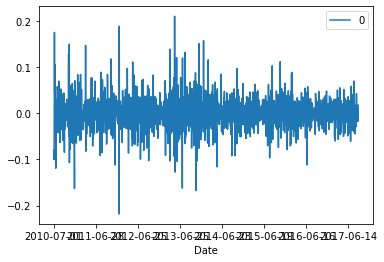

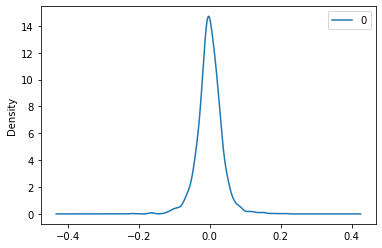

                 0
count  1810.000000
mean     -0.000070
std       0.034902
min      -0.218084
25%      -0.017828
50%      -0.001273
75%       0.018148
max       0.210245


In [17]:
model = ARIMA(train, order=(5,1,0))
model_fit = model.fit(disp=0)
print(model_fit.summary())
# plot residual errors
residuals = DataFrame(model_fit.resid)
residuals.plot()
plt.show()
residuals.plot(kind='kde')
plt.show()
print(residuals.describe())

In [18]:
# Forecast
fc, se, conf = model_fit.forecast(604, alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test.index)
lower_series = pd.Series(conf[:, 0], index=test.index)
upper_series = pd.Series(conf[:, 1], index=test.index)

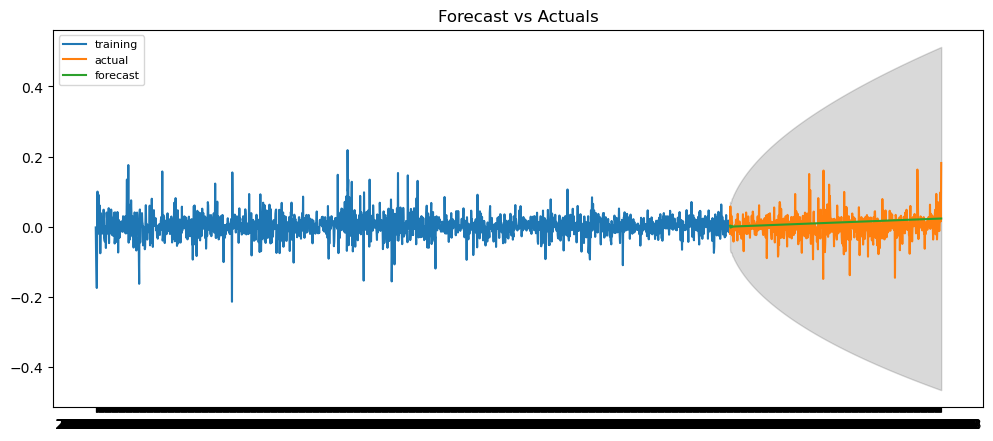

In [19]:
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [20]:
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    
   
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse})

forecast_accuracy(fc, test.values)

{'mape': inf,
 'me': 0.009996574500705149,
 'mae': 0.02501039169029781,
 'mpe': inf,
 'rmse': 0.03501866369609812}